<a href="https://colab.research.google.com/github/eight42910/learning-tracker/blob/main/Ames4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#データの準備

In [10]:
#データの読み込み
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split,GridSearchCV, cross_val_score
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor

%matplotlib inline


dir_path = "/content/drive/MyDrive/DS_Ames/"

#データの読み込み
train_file = 'アメリカの住宅価格予測 train.csv'
test_file = 'アメリカの都市エイムズ 住宅価格予測.csv'
provided_submission = 'アメリカの都市エイムズ 住宅価格予測 提出.csv'

train_df = pd.read_csv(dir_path + train_file)
test_df = pd.read_csv(dir_path + test_file)
provided_submission = pd.read_csv(dir_path + provided_submission, header=None)

In [ ]:
# データ確認
print("学習データ:")
print(train_df.info())
print(train_df.describe())

print("\nテストデータ:")
print(test_df.info())
print(test_df.describe())

学習データ:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3000 entries, 0 to 2999
Data columns (total 47 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   index           3000 non-null   int64  
 1   Order           3000 non-null   int64  
 2   MS SubClass     3000 non-null   int64  
 3   MS Zoning       3000 non-null   object 
 4   Lot Area        3000 non-null   int64  
 5   Lot Shape       3000 non-null   object 
 6   Land Contour    3000 non-null   object 
 7   Lot Config      3000 non-null   object 
 8   Neighborhood    3000 non-null   object 
 9   Bldg Type       3000 non-null   object 
 10  House Style     3000 non-null   object 
 11  Overall Qual    3000 non-null   int64  
 12  Overall Cond    3000 non-null   int64  
 13  Year Built      3000 non-null   int64  
 14  Year Remod/Add  3000 non-null   int64  
 15  Roof Style      3000 non-null   object 
 16  Exterior 1st    3000 non-null   object 
 17  Exterior 2nd    3000 non-n

#分布の確認

In [ ]:
# 主な数値型変数の分布確認
numerical_features = [
    'SalePrice', 'Lot Area', 'Gr Liv Area', 'Year Built', 'Garage Area',
    'Total Bsmt SF', '1st Flr SF', 'Wood Deck SF', 'Open Porch SF'
]

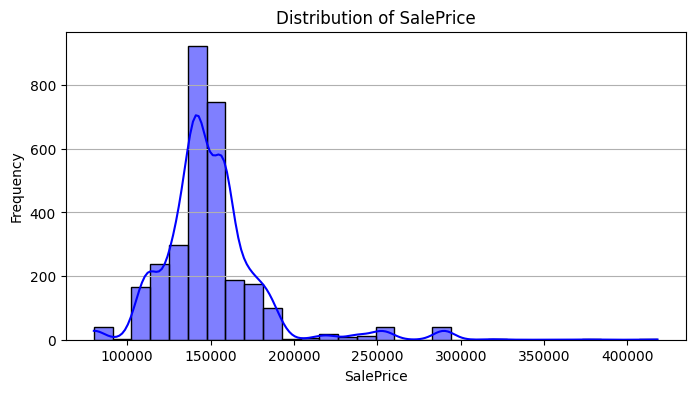

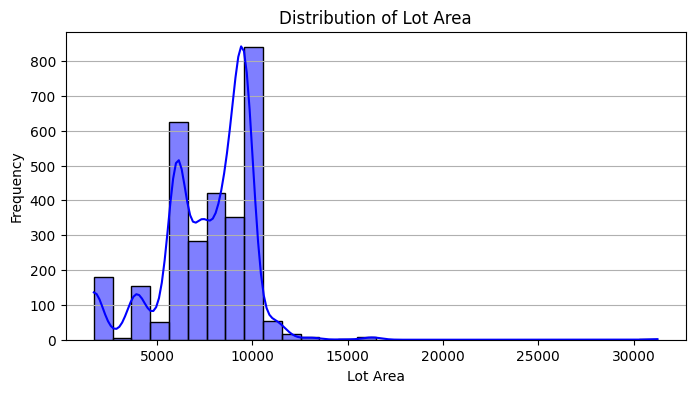

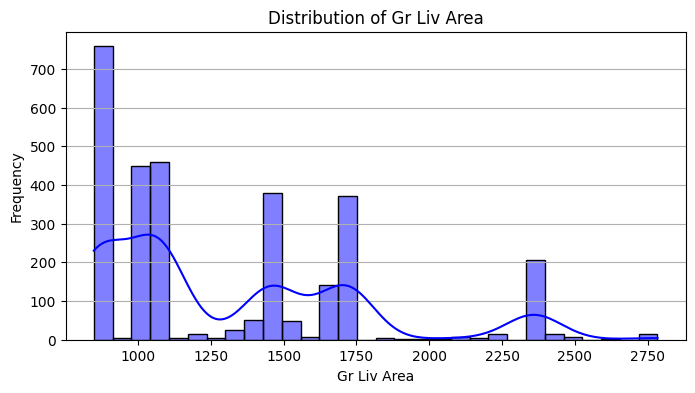

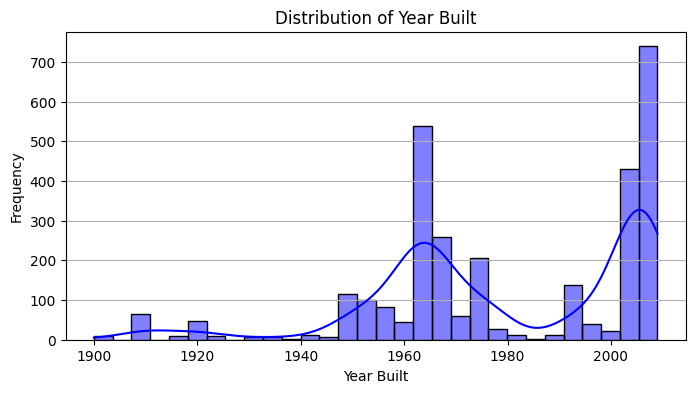

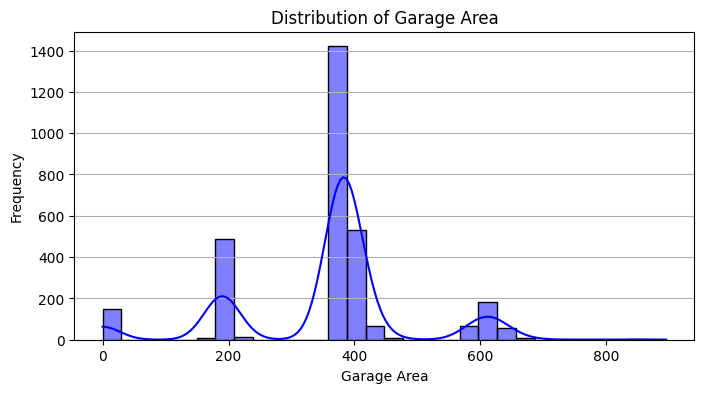

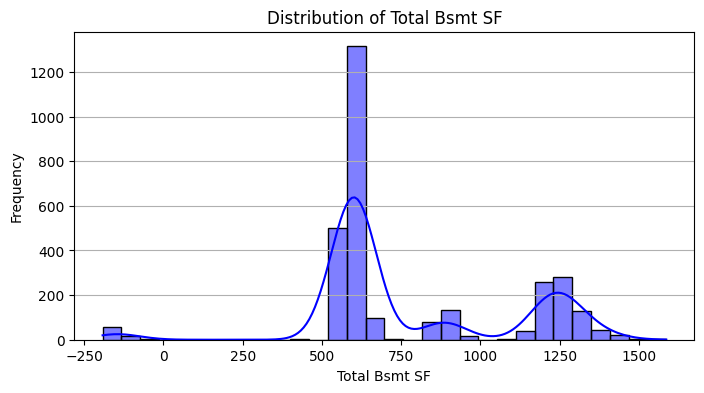

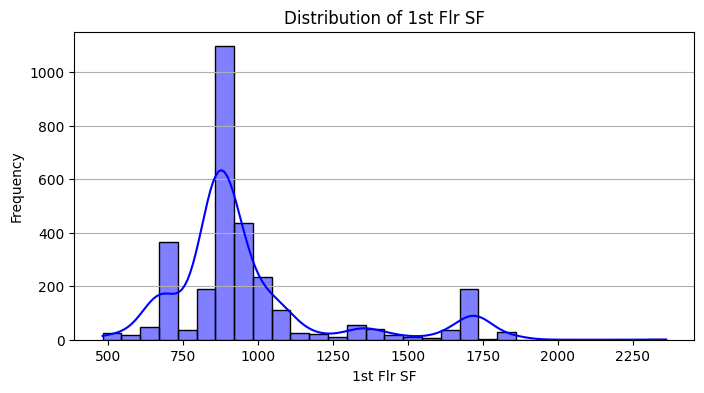

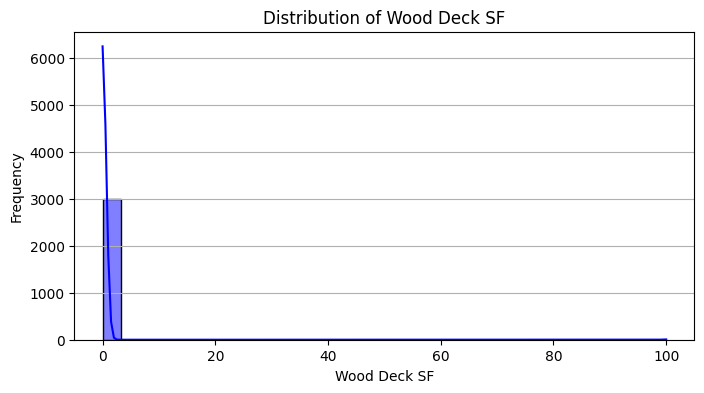

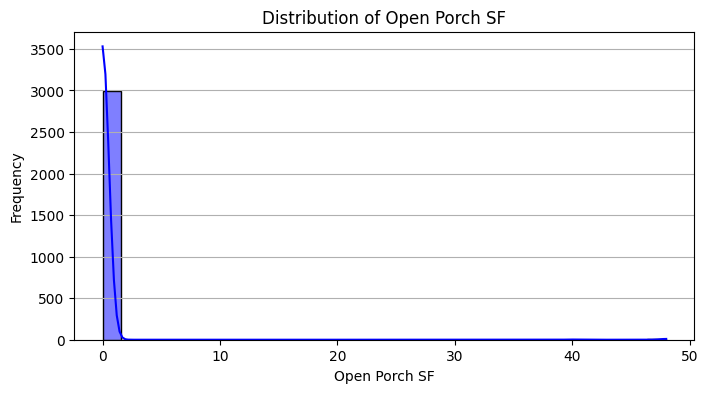

In [ ]:
# 分布の可視化
for feature in numerical_features:
    plt.figure(figsize=(8, 4))
    sns.histplot(train_df[feature], kde=True, bins=30, color='blue', edgecolor='k')
    plt.title(f"Distribution of {feature}")
    plt.xlabel(feature)
    plt.ylabel("Frequency")
    plt.grid(axis='y')
    plt.show()

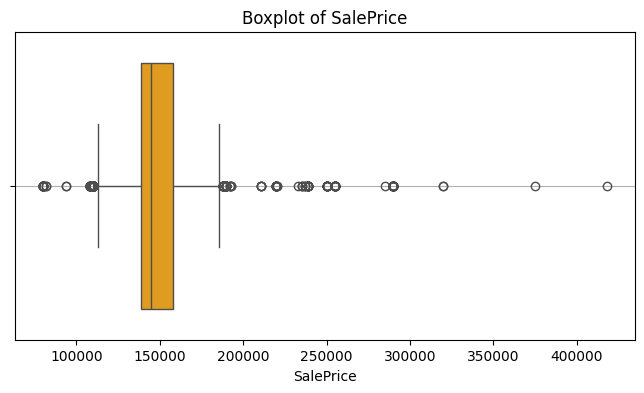

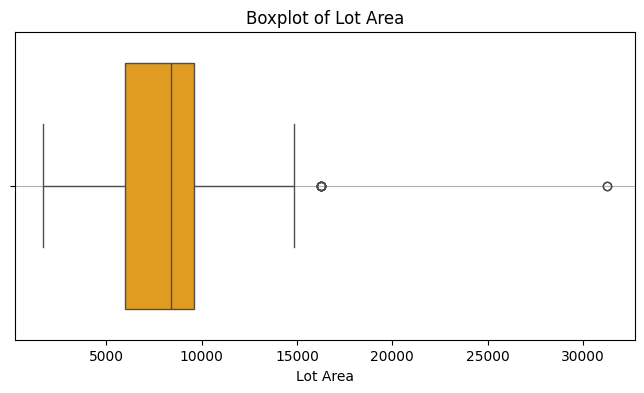

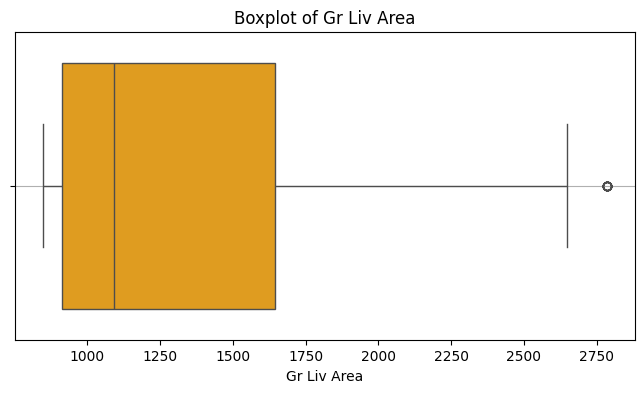

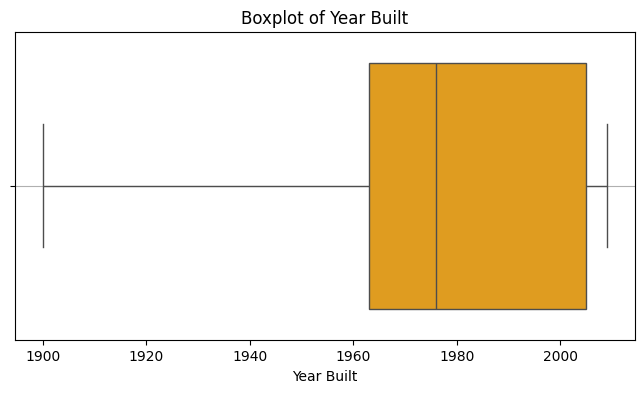

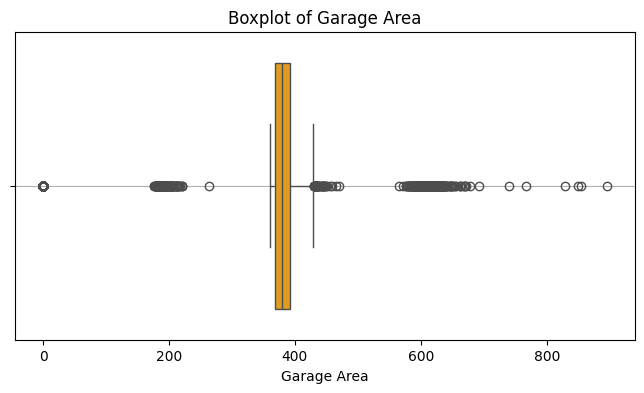

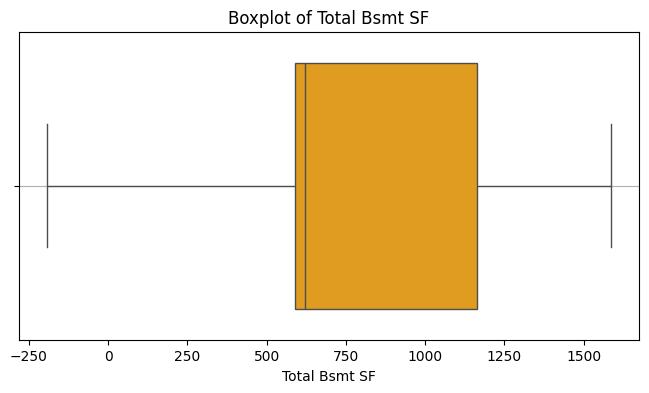

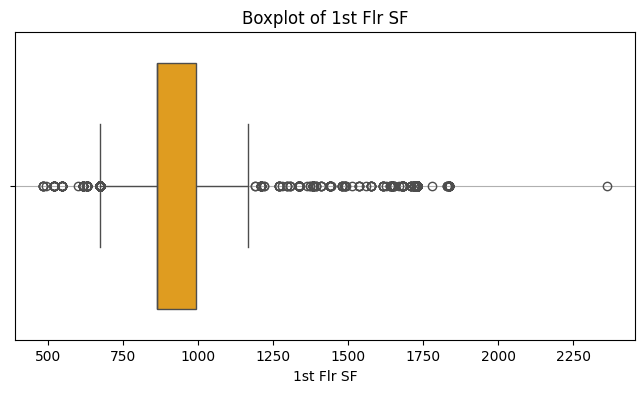

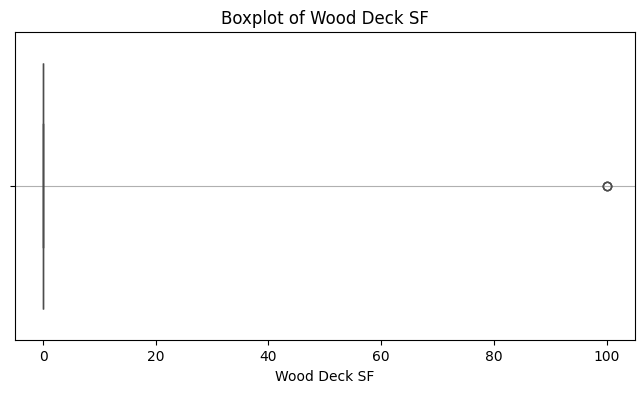

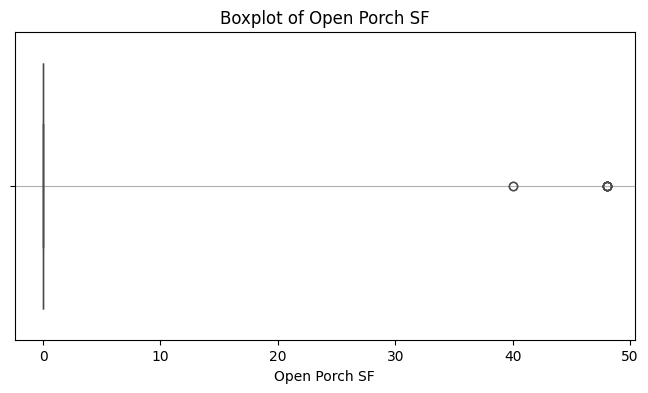

In [ ]:
# Boxplotで外れ値を検出する
for feature in numerical_features:
    plt.figure(figsize=(8, 4))
    sns.boxplot(x=train_df[feature], color='orange')
    plt.title(f"Boxplot of {feature}")
    plt.xlabel(feature)
    plt.grid(axis='y')
    plt.show()

In [ ]:
# 外れ値を定量的に検出（例: IQR法）
outliers = {}
for feature in numerical_features:
    Q1 = train_df[feature].quantile(0.25)
    Q3 = train_df[feature].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    outlier_count = train_df[(train_df[feature] < lower_bound) | (train_df[feature] > upper_bound)].shape[0]
    outliers[feature] = outlier_count


In [ ]:
# 外れ値の件数をまとめる
outliers_df = pd.DataFrame.from_dict(outliers, orient='index', columns=['Outlier Count'])
outliers_df.sort_values(by='Outlier Count', ascending=False, inplace=True)
print(outliers_df)

               Outlier Count
Garage Area             1015
1st Flr SF               775
SalePrice                374
Gr Liv Area               14
Lot Area                  10
Open Porch SF             10
Wood Deck SF               3
Year Built                 0
Total Bsmt SF              0


#外れ値の処理

In [ ]:
# 処理対象の特徴量
outlier_features = ['Garage Area', '1st Flr SF', 'SalePrice']

In [2]:
# 外れ値の処理
outlier_features = ['Garage Area', '1st Flr SF', 'SalePrice']
for feature in outlier_features:
    Q1 = train_df[feature].quantile(0.25)
    Q3 = train_df[feature].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    train_df[feature] = np.clip(train_df[feature], lower_bound, upper_bound)

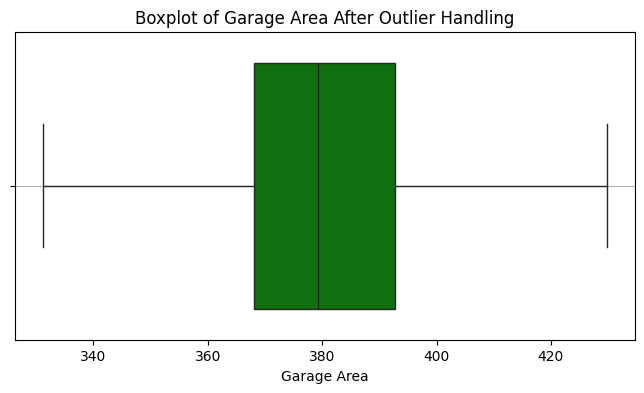

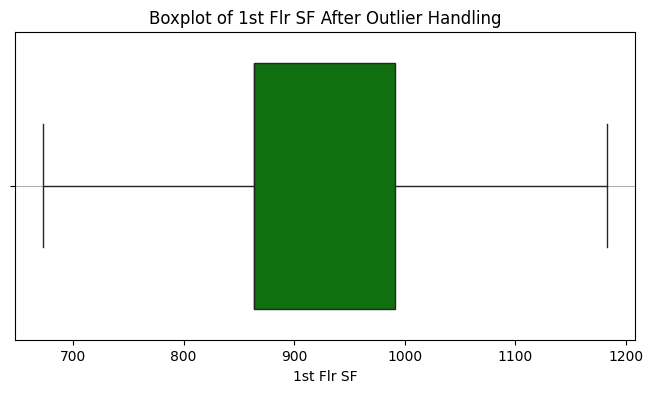

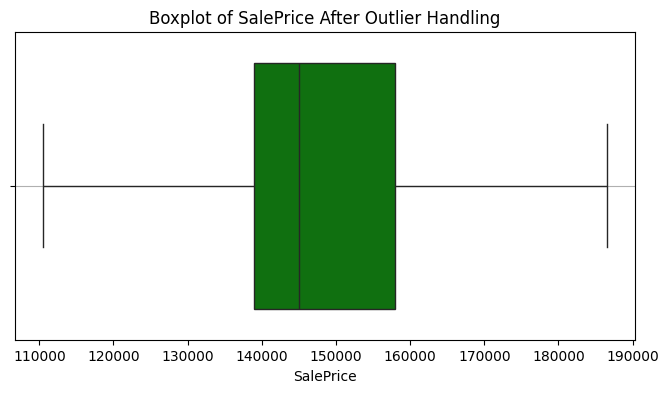

       Garage Area   1st Flr SF      SalePrice
count  3000.000000  3000.000000    3000.000000
mean    377.893557   915.313417  147682.508667
std      30.300455   149.901963   20547.292081
min     331.192088   672.750000  110500.000000
25%     368.150937   864.000000  139000.000000
50%     379.312837   864.000000  145000.000000
75%     392.790170   991.500000  158000.000000
max     429.749019  1182.750000  186500.000000


In [ ]:
# 処理結果の確認
for feature in outlier_features:
    plt.figure(figsize=(8, 4))
    sns.boxplot(x=train_df[feature], color='green')
    plt.title(f"Boxplot of {feature} After Outlier Handling")
    plt.xlabel(feature)
    plt.grid(axis='y')
    plt.show()

# 処理後のデータ確認
print(train_df[outlier_features].describe())

#相関分析と特徴量の理解


Correlation with SalePrice:
SalePrice         1.000000
Full Bath         0.355092
Gr Liv Area       0.290633
Garage Cars       0.266367
Year Built        0.222007
Garage Area       0.220860
Half Bath         0.172484
Bsmt Full Bath    0.155272
Overall Qual      0.130655
Fireplaces        0.127351
1st Flr SF        0.106945
Lot Area          0.092234
Year Remod/Add    0.091986
Total Bsmt SF     0.089350
Bsmt Unf SF       0.088651
Open Porch SF     0.073134
Order             0.067251
Wood Deck SF      0.051311
BsmtFin SF 1      0.051128
Mo Sold           0.044412
MS SubClass       0.043225
2nd Flr SF        0.042508
index             0.008562
TotRms AbvGrd    -0.021503
Kitchen AbvGr    -0.022098
Bedroom AbvGr    -0.060872
Overall Cond     -0.069642
Yr Sold          -0.078844
Name: SalePrice, dtype: float64


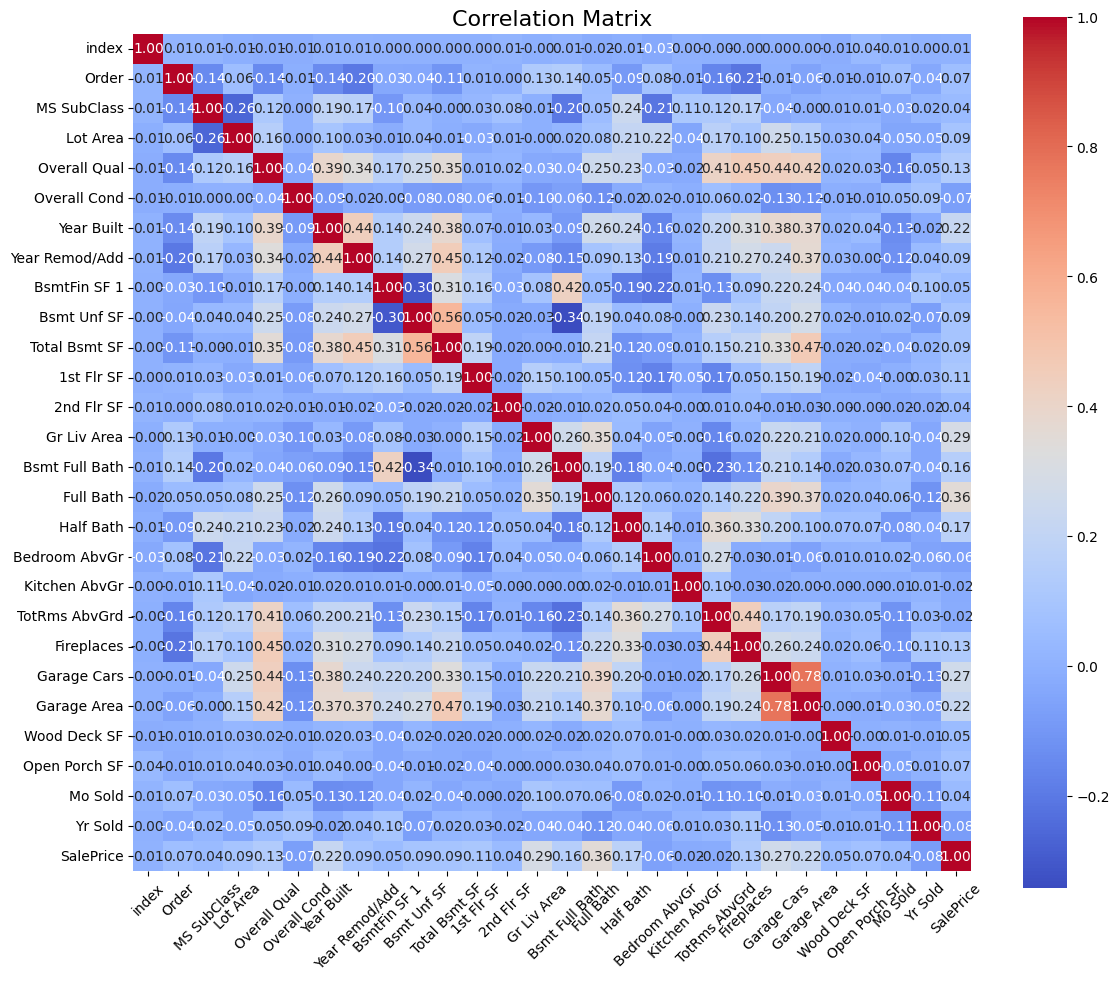

In [ ]:
# 数値型特徴量とターゲット変数(SalePrice)の相関
numerical_features = train_df.select_dtypes(include=['float64', 'int64']).columns
correlation_matrix = train_df[numerical_features].corr()

# SalePriceとの相関をソート
saleprice_correlation = correlation_matrix["SalePrice"].sort_values(ascending=False)
print("\nCorrelation with SalePrice:")
print(saleprice_correlation)

# 相関ヒートマップの描画
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap="coolwarm", cbar=True, square=True)
plt.title("Correlation Matrix", fontsize=16)
plt.xticks(fontsize=10, rotation=45)
plt.yticks(fontsize=10)
plt.tight_layout()
plt.show()

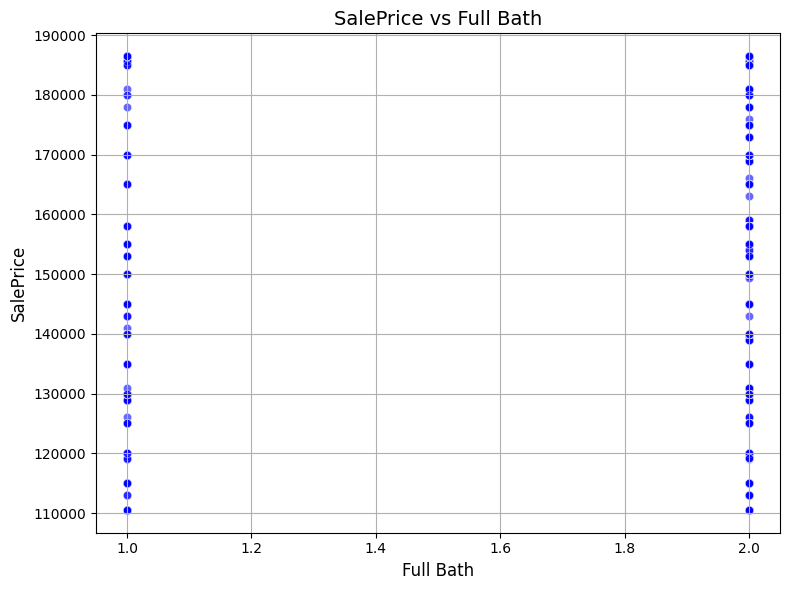

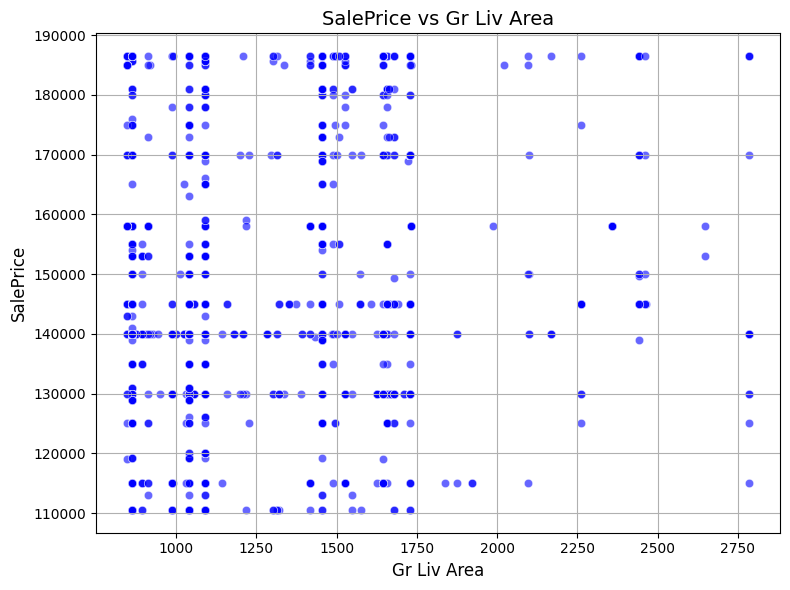

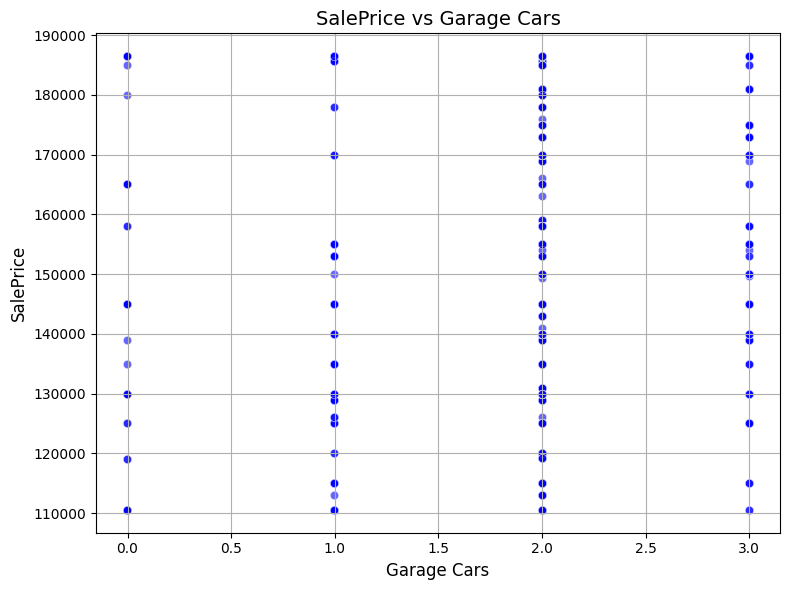

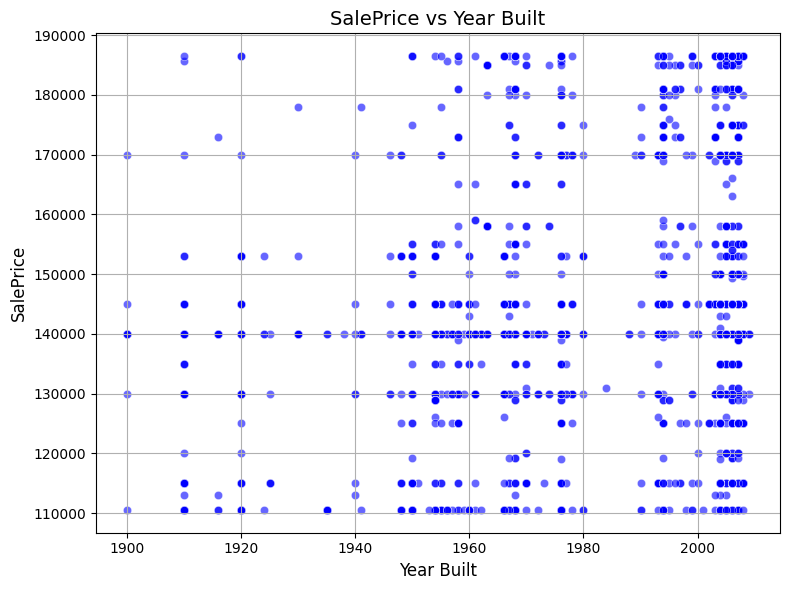

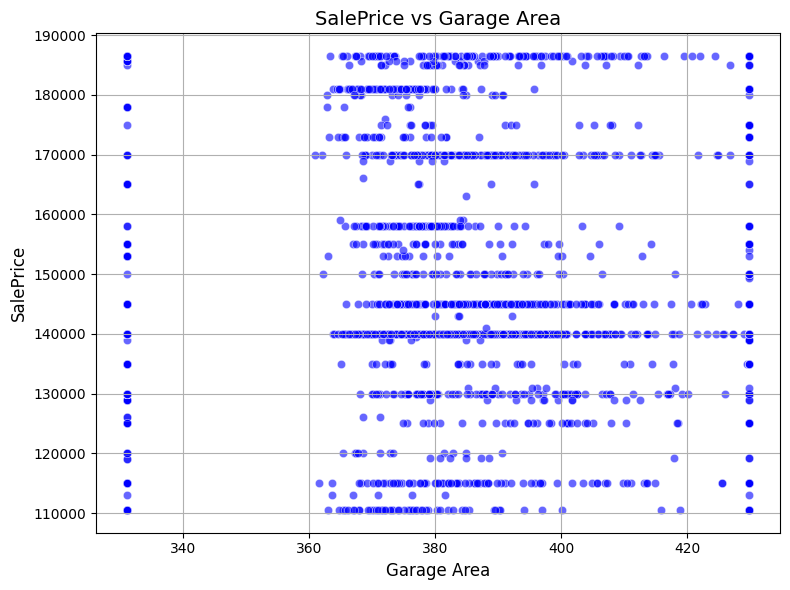

<ipython-input-12-d4bdc18d0d0e>:17: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x=train_df[feature], y=train_df['SalePrice'], palette="Set2")


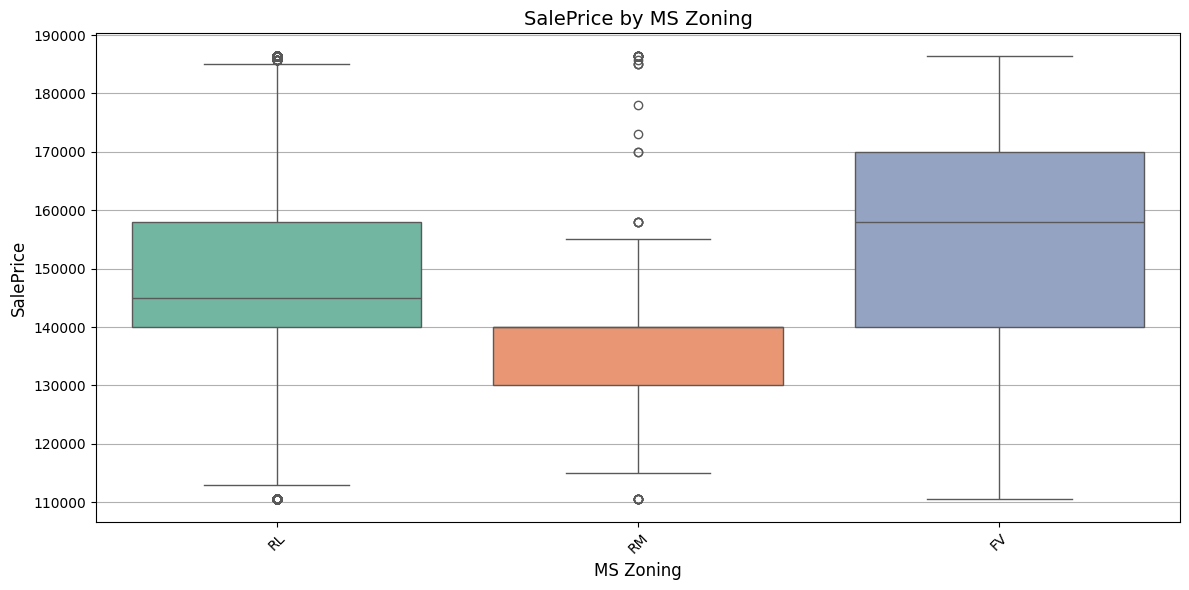

<ipython-input-12-d4bdc18d0d0e>:17: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x=train_df[feature], y=train_df['SalePrice'], palette="Set2")


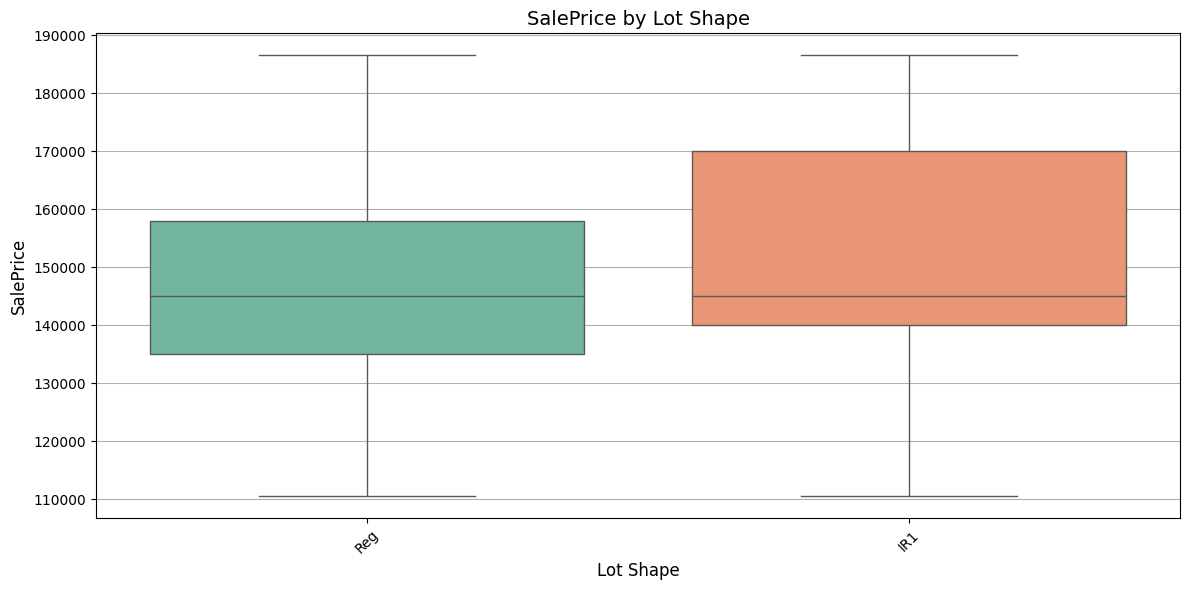

<ipython-input-12-d4bdc18d0d0e>:17: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x=train_df[feature], y=train_df['SalePrice'], palette="Set2")


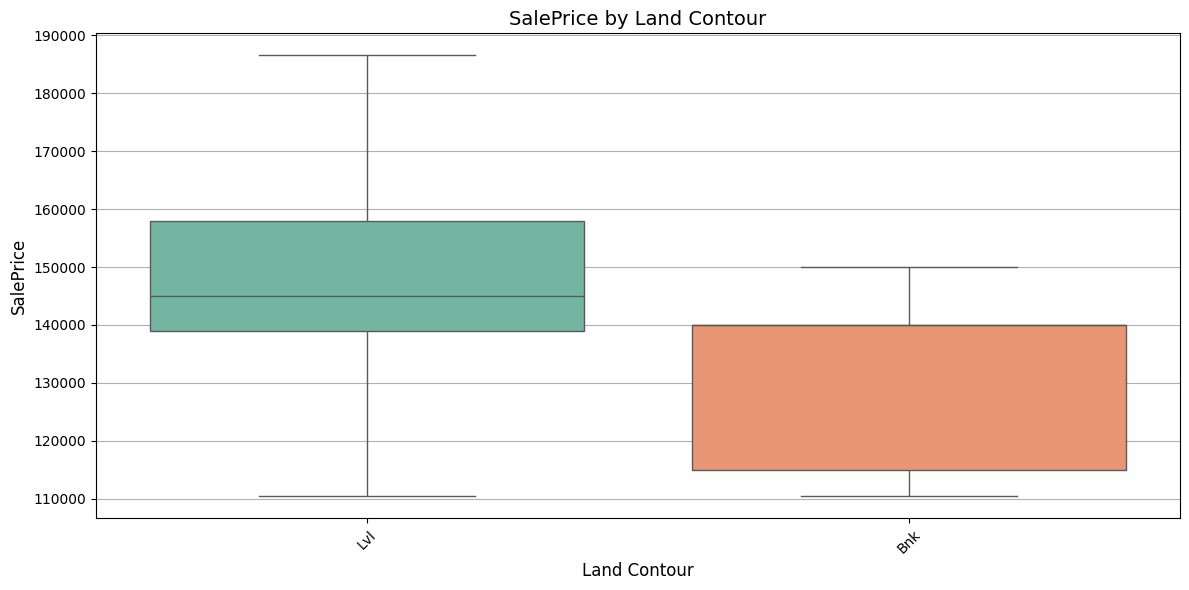

<ipython-input-12-d4bdc18d0d0e>:17: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x=train_df[feature], y=train_df['SalePrice'], palette="Set2")


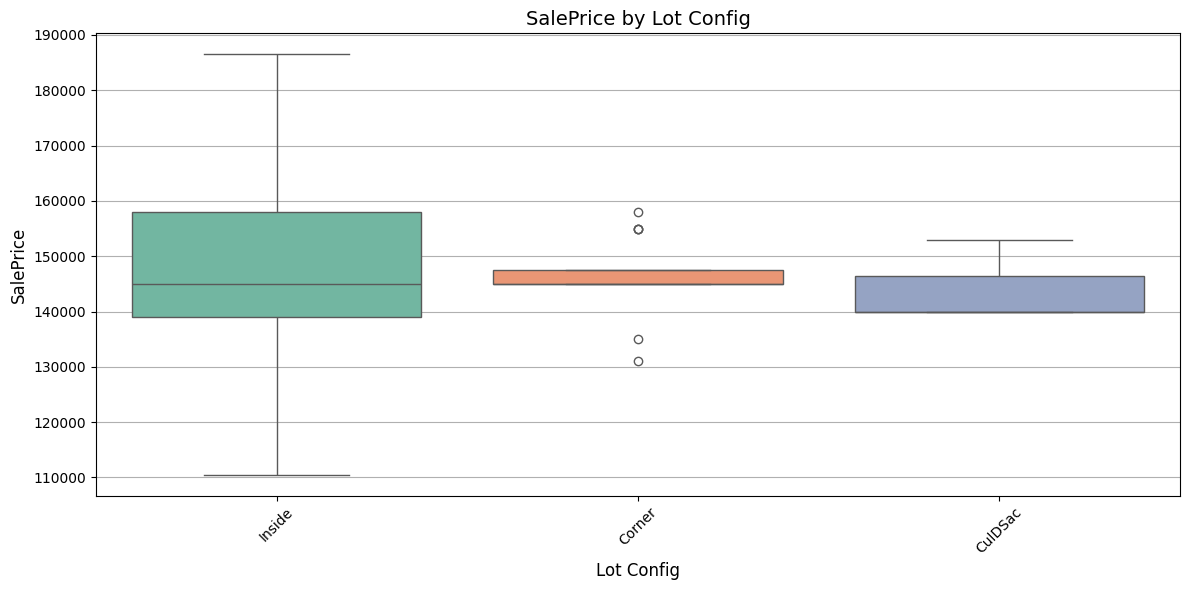

<ipython-input-12-d4bdc18d0d0e>:17: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x=train_df[feature], y=train_df['SalePrice'], palette="Set2")


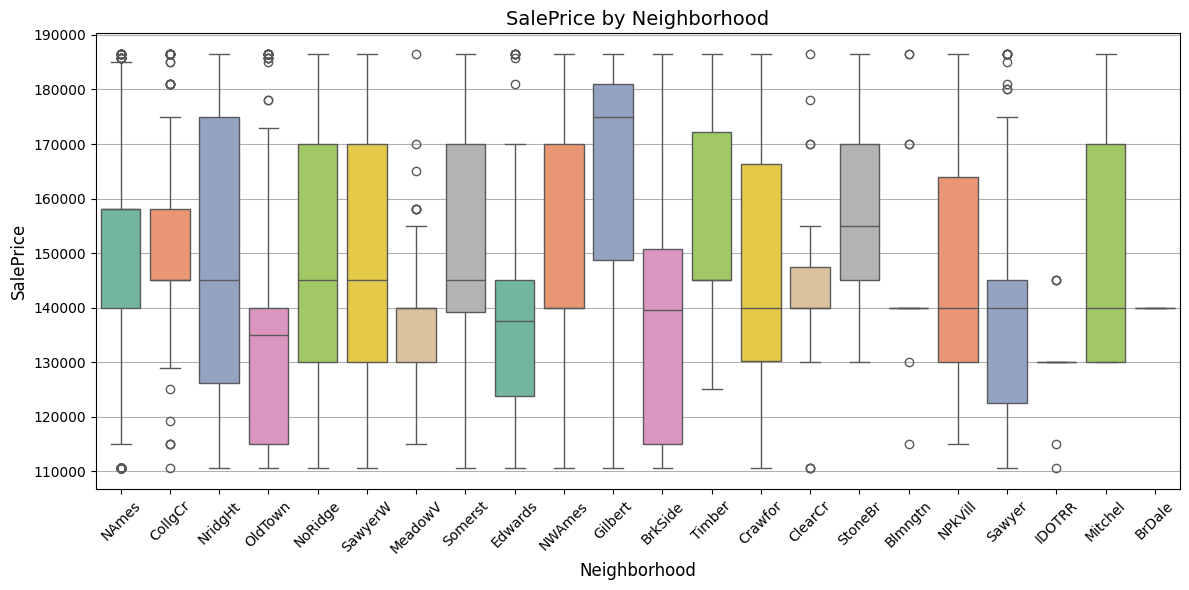

<ipython-input-12-d4bdc18d0d0e>:17: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x=train_df[feature], y=train_df['SalePrice'], palette="Set2")


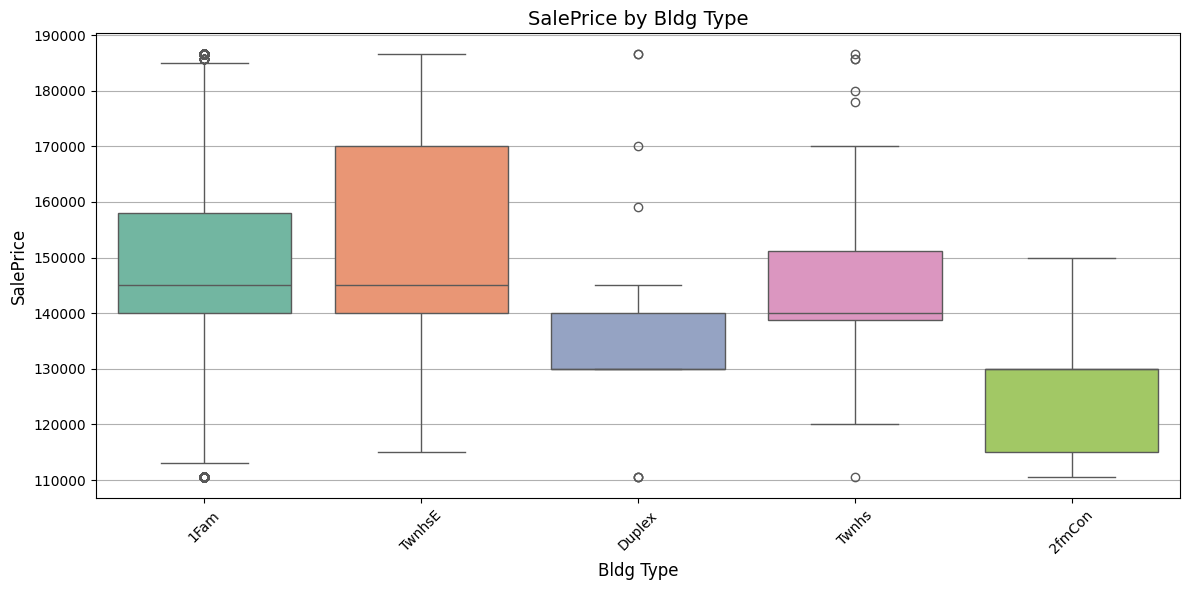

<ipython-input-12-d4bdc18d0d0e>:17: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x=train_df[feature], y=train_df['SalePrice'], palette="Set2")


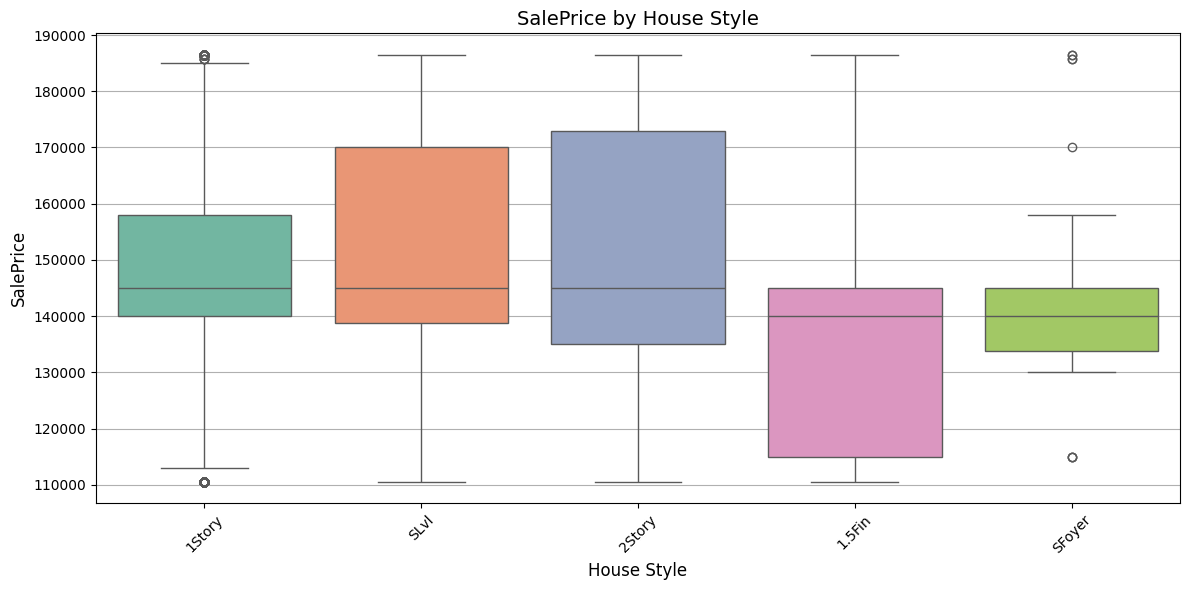

<ipython-input-12-d4bdc18d0d0e>:17: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x=train_df[feature], y=train_df['SalePrice'], palette="Set2")


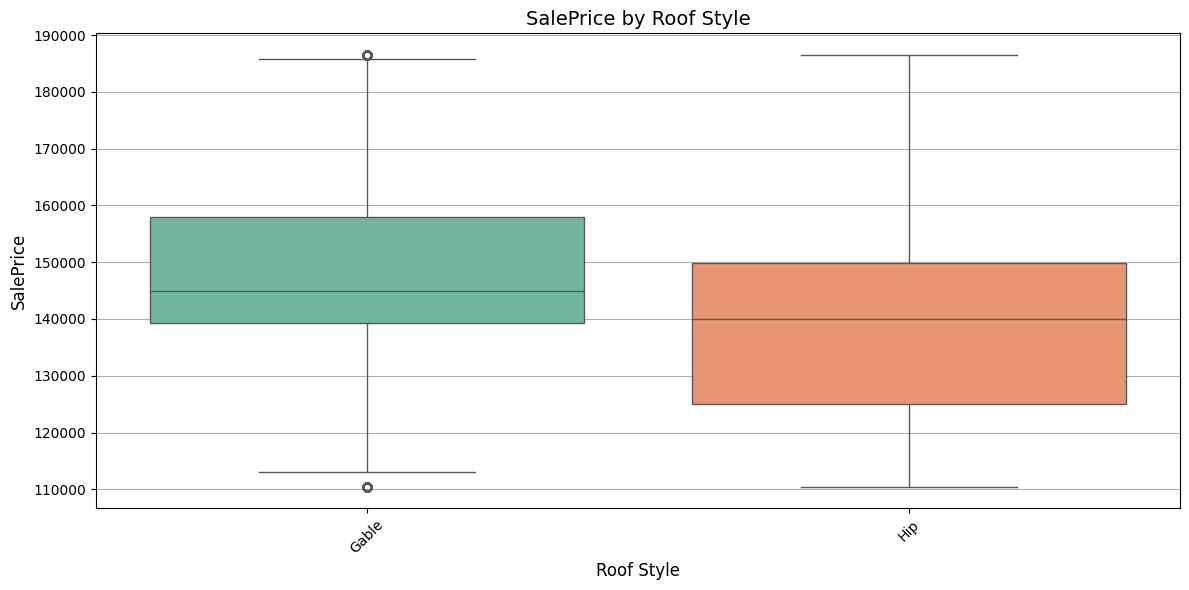

<ipython-input-12-d4bdc18d0d0e>:17: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x=train_df[feature], y=train_df['SalePrice'], palette="Set2")


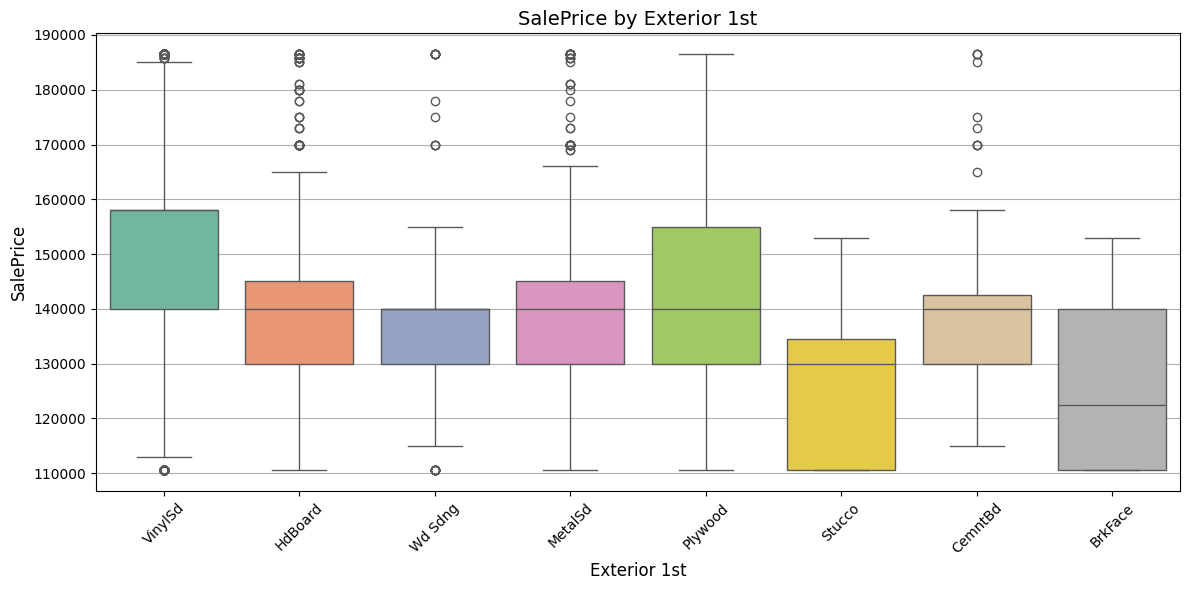

<ipython-input-12-d4bdc18d0d0e>:17: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x=train_df[feature], y=train_df['SalePrice'], palette="Set2")


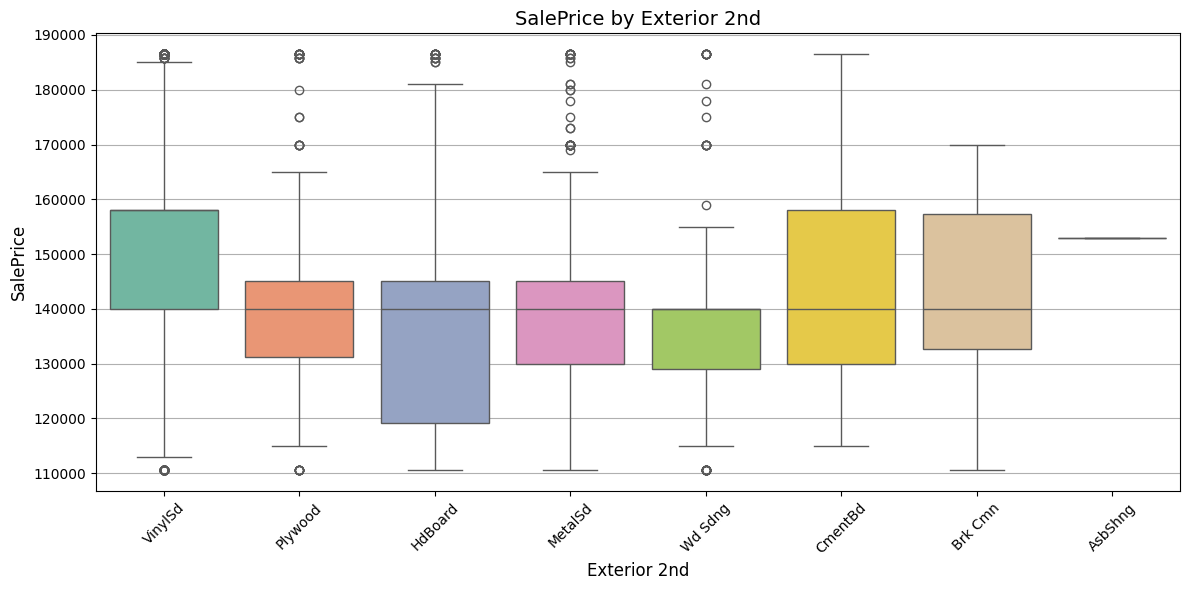

<ipython-input-12-d4bdc18d0d0e>:17: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x=train_df[feature], y=train_df['SalePrice'], palette="Set2")


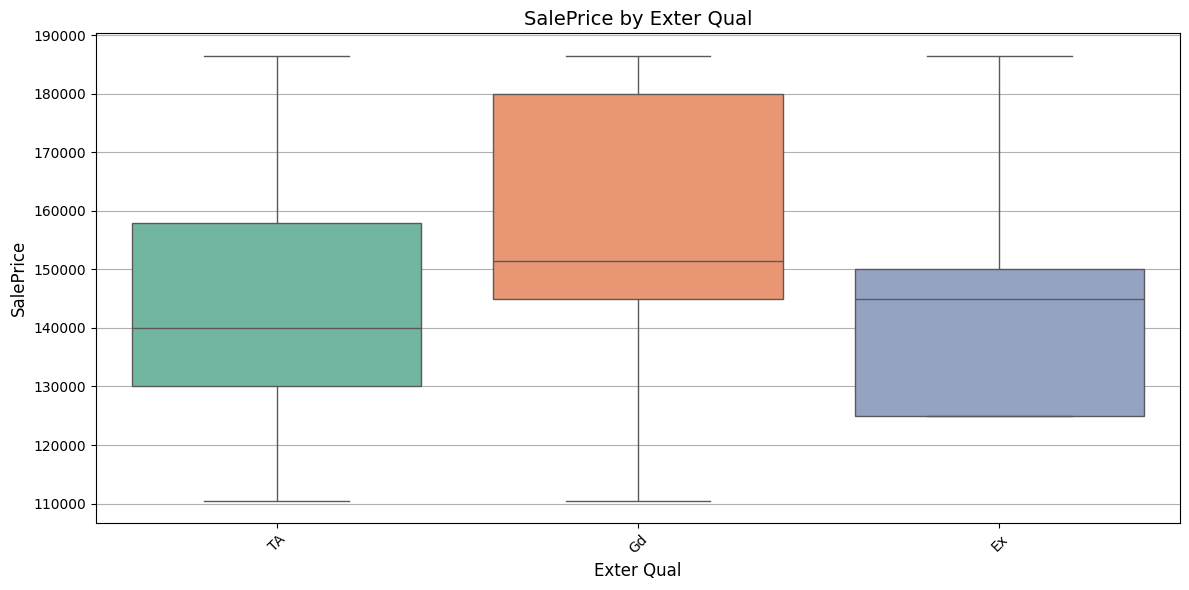

<ipython-input-12-d4bdc18d0d0e>:17: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x=train_df[feature], y=train_df['SalePrice'], palette="Set2")


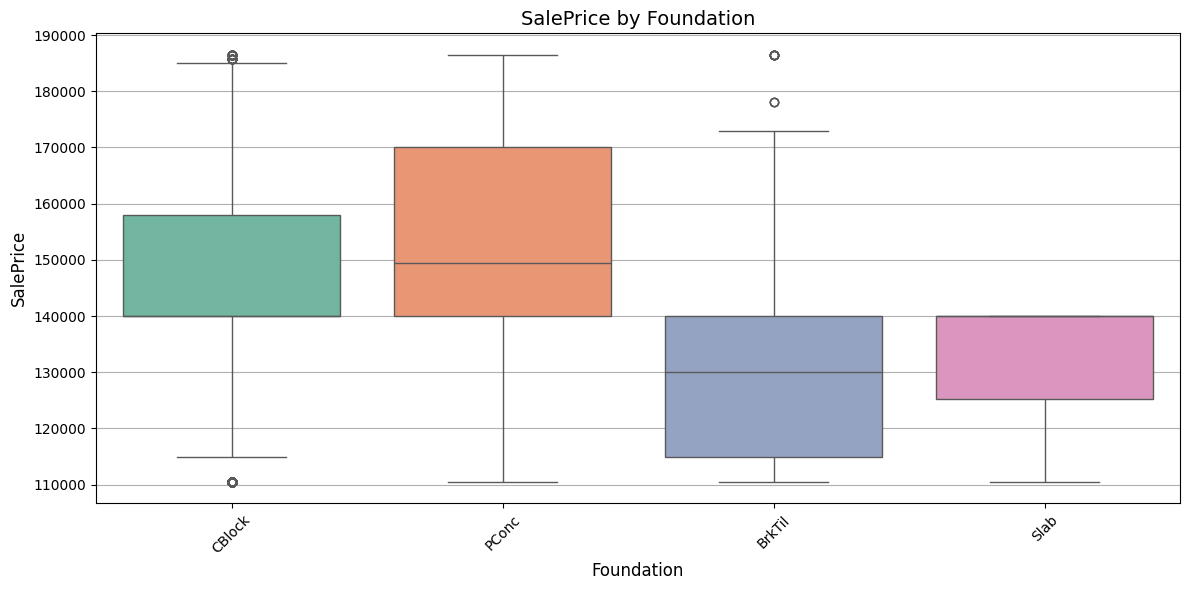

<ipython-input-12-d4bdc18d0d0e>:17: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x=train_df[feature], y=train_df['SalePrice'], palette="Set2")


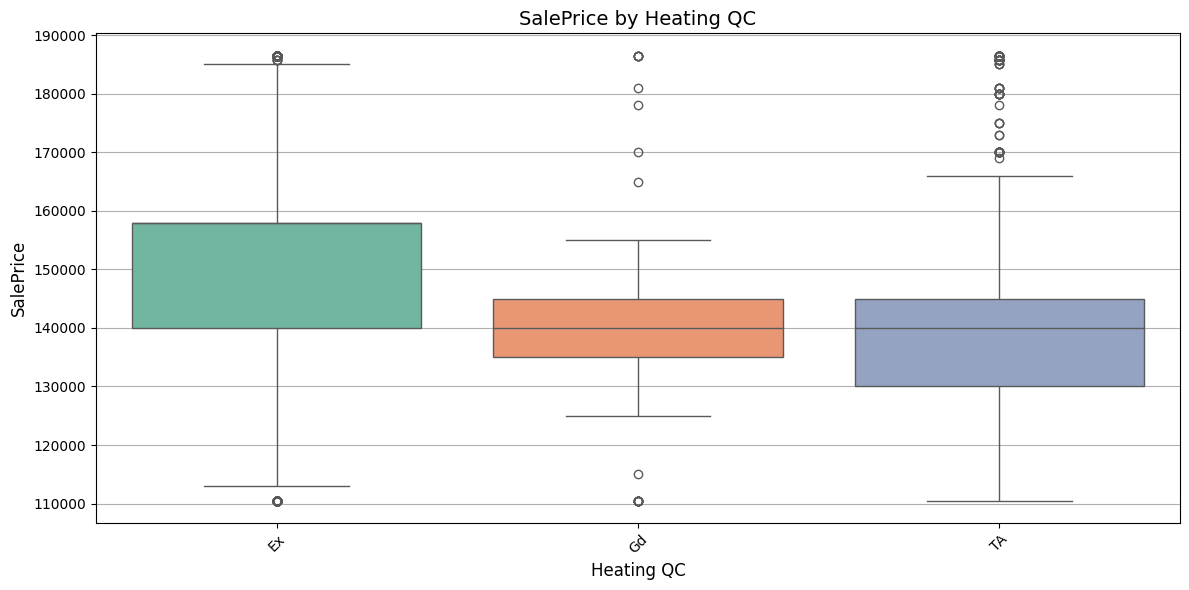

<ipython-input-12-d4bdc18d0d0e>:17: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x=train_df[feature], y=train_df['SalePrice'], palette="Set2")


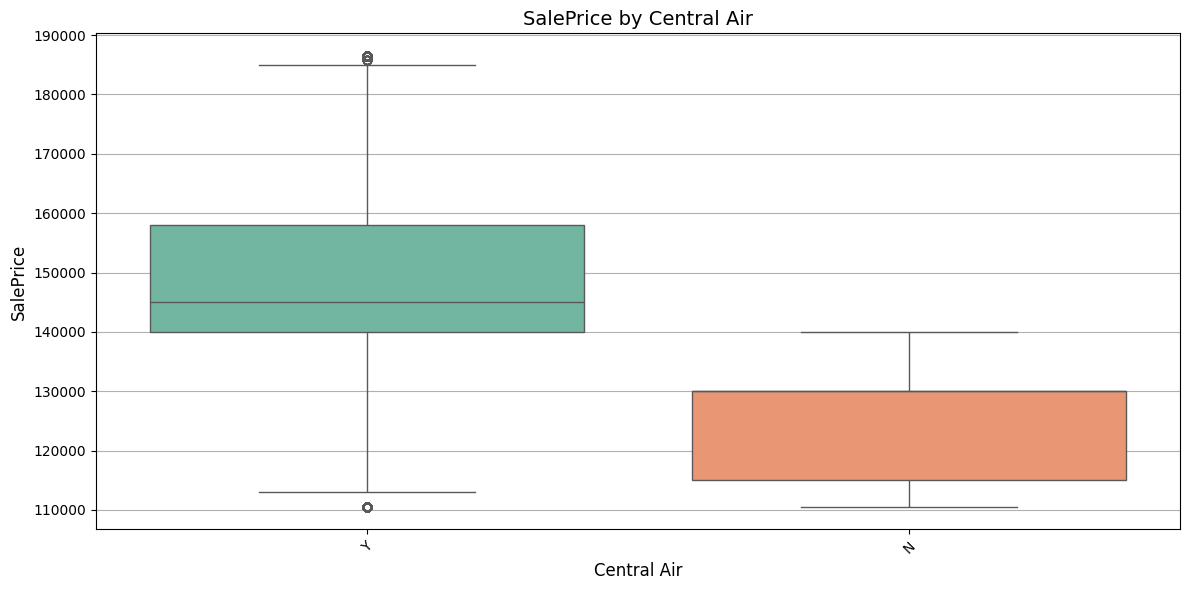

<ipython-input-12-d4bdc18d0d0e>:17: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x=train_df[feature], y=train_df['SalePrice'], palette="Set2")


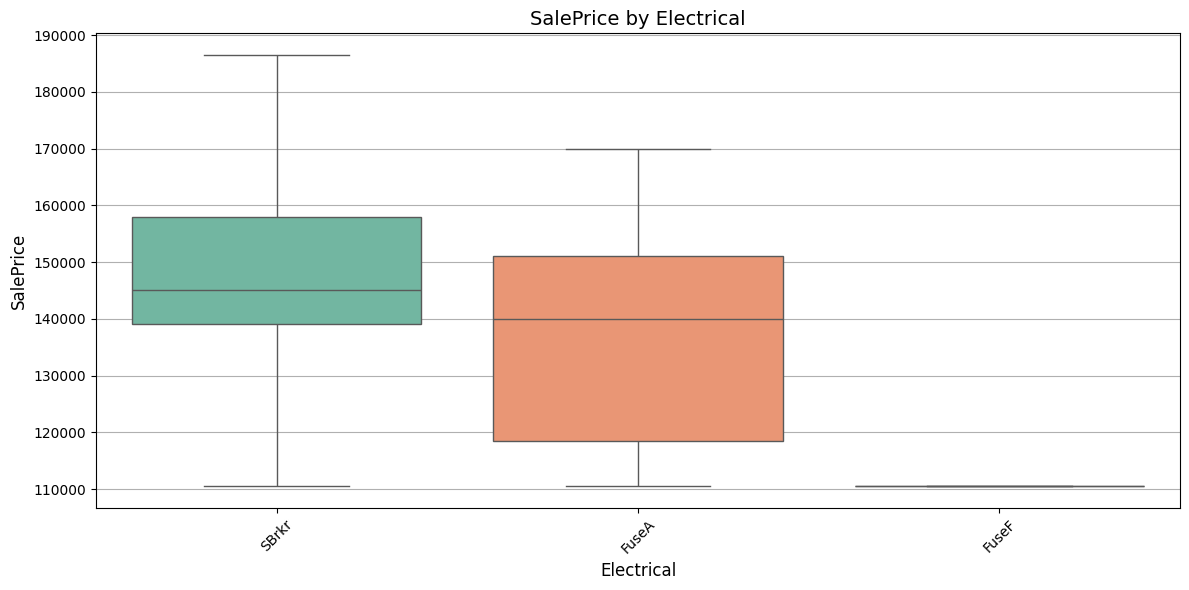

<ipython-input-12-d4bdc18d0d0e>:17: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x=train_df[feature], y=train_df['SalePrice'], palette="Set2")


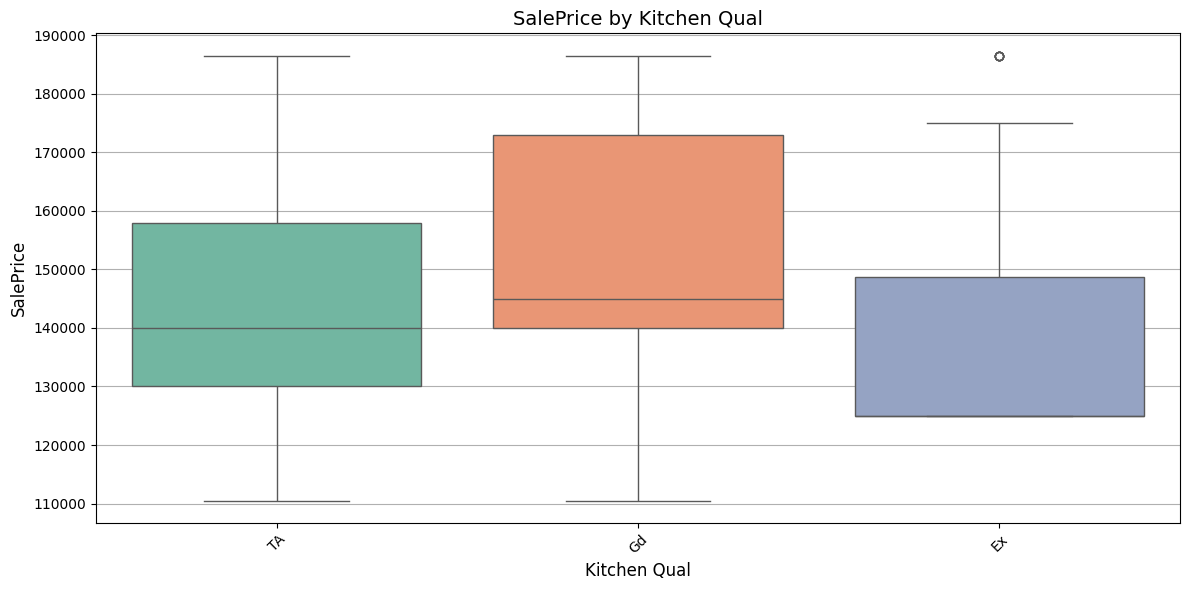

<ipython-input-12-d4bdc18d0d0e>:17: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x=train_df[feature], y=train_df['SalePrice'], palette="Set2")


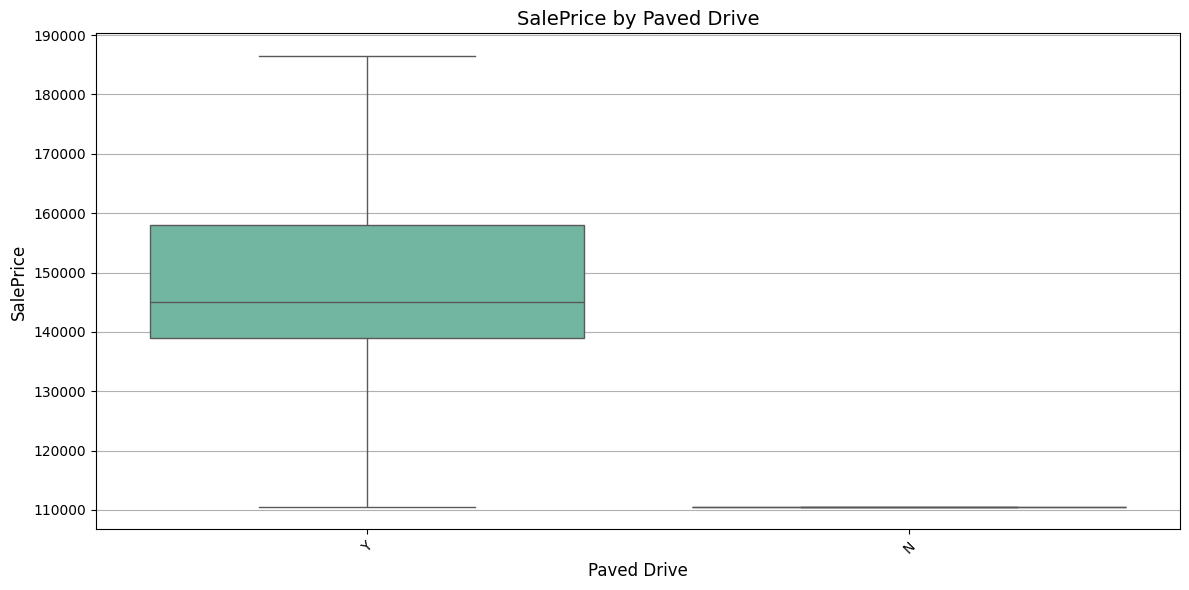

<ipython-input-12-d4bdc18d0d0e>:17: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x=train_df[feature], y=train_df['SalePrice'], palette="Set2")


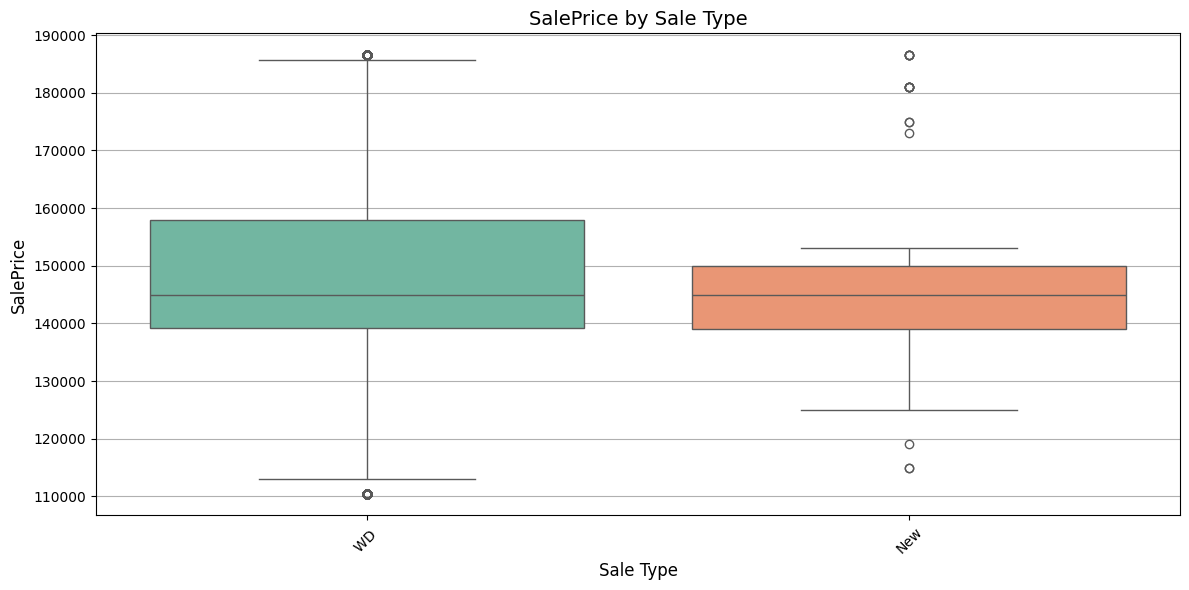

<ipython-input-12-d4bdc18d0d0e>:17: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x=train_df[feature], y=train_df['SalePrice'], palette="Set2")


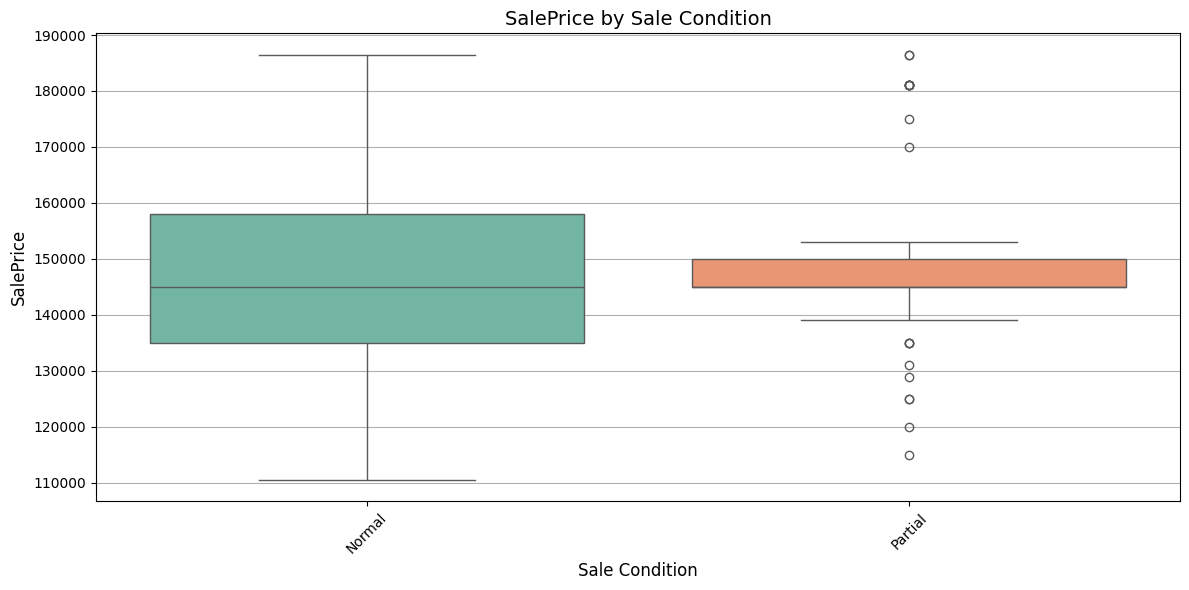

In [ ]:

# SalePriceと相関が高い変数の散布図
important_features = saleprice_correlation.index[1:6]  # 上位5つを選択
for feature in important_features:
    plt.figure(figsize=(8, 6))
    sns.scatterplot(x=train_df[feature], y=train_df['SalePrice'], alpha=0.6, color='blue')
    plt.title(f"SalePrice vs {feature}", fontsize=14)
    plt.xlabel(feature, fontsize=12)
    plt.ylabel("SalePrice", fontsize=12)
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# カテゴリ型特徴量とSalePriceの関係
categorical_features = train_df.select_dtypes(include=['object']).columns
for feature in categorical_features:
    plt.figure(figsize=(12, 6))
    sns.boxplot(x=train_df[feature], y=train_df['SalePrice'], palette="Set2")
    plt.title(f"SalePrice by {feature}", fontsize=14)
    plt.xlabel(feature, fontsize=12)
    plt.ylabel("SalePrice", fontsize=12)
    plt.xticks(rotation=45, fontsize=10)
    plt.grid(True, axis='y')
    plt.tight_layout()
    plt.show()



#特徴量の選定プロセス


In [ ]:
# 相関が高い数値型特徴量を選定
threshold = 0.5  # 相関係数のしきい値
important_numeric_features = saleprice_correlation[saleprice_correlation > threshold].index.tolist()
print("\nSelected Numeric Features:")
print(important_numeric_features)


Selected Numeric Features:
['SalePrice']


In [ ]:
# カテゴリ型特徴量とSalePriceの関係
categorical_features = train_df.select_dtypes(include=['object']).columns
important_categorical_features = []

for feature in categorical_features:
    categories_mean = train_df.groupby(feature)['SalePrice'].mean()
    if categories_mean.max() - categories_mean.min() > 0.1 * train_df['SalePrice'].mean():  # 差が十分大きい場合
        important_categorical_features.append(feature)

print("\nSelected Categorical Features:")
print(important_categorical_features)


Selected Categorical Features:
['MS Zoning', 'Land Contour', 'Neighborhood', 'Bldg Type', 'Exterior 1st', 'Exterior 2nd', 'Foundation', 'Central Air', 'Electrical', 'Paved Drive']


In [ ]:
# 最終的な重要特徴量リスト
final_selected_features = important_numeric_features + important_categorical_features
print("\nFinal Selected Features for Modeling:")
print(final_selected_features)



Final Selected Features for Modeling:
['SalePrice', 'MS Zoning', 'Land Contour', 'Neighborhood', 'Bldg Type', 'Exterior 1st', 'Exterior 2nd', 'Foundation', 'Central Air', 'Electrical', 'Paved Drive']


#特徴量決定

In [3]:
# 重要な特徴量の選定結果
selected_features = ['MS Zoning', 'Land Contour', 'Neighborhood', 'Bldg Type', 'Exterior 1st', 'Exterior 2nd', 'Foundation', 'Central Air', 'Electrical', 'Paved Drive']

#新しい特徴量

In [4]:
# 新しい特徴量の作成
train_df['Total Area'] = train_df['1st Flr SF'] + train_df['Garage Area'] + train_df['Total Bsmt SF']
train_df['Price per Area'] = train_df['SalePrice'] / (train_df['1st Flr SF'] + 1)
train_df['Has Garage'] = (train_df['Garage Area'] > 0).astype(int)
test_df['Total Area'] = test_df['1st Flr SF'] + test_df['Garage Area'] + test_df['Total Bsmt SF']
test_df['Price per Area'] = test_df['1st Flr SF'] / (test_df['1st Flr SF'] + 1)
test_df['Has Garage'] = (test_df['Garage Area'] > 0).astype(int)


#分離とエンコード、val分割

In [5]:
# ターゲット変数と特徴量の分離
y = train_df['SalePrice']
selected_features = ['MS Zoning', 'Land Contour', 'Neighborhood', 'Bldg Type', 'Exterior 1st', 'Exterior 2nd', 'Foundation', 'Central Air', 'Electrical', 'Paved Drive', 'Total Area', 'Price per Area', 'Has Garage']
X_train = train_df[selected_features]
X_test = test_df[selected_features]

#低重要度の特徴量選定
low_importance_features = ['Electrical_FuseF', 'Foundation_Slab', 'Paved Drive_Y', 'Neighborhood_BrDale']

# カテゴリ型変数のエンコード（One-Hot Encoding）
X_train_encoded = pd.get_dummies(X_train, drop_first=True)
X_test_encoded = pd.get_dummies(X_test, drop_first=True)

# テストデータと学習データの列を揃える
X_test_encoded = X_test_encoded.reindex(columns=X_train_encoded.columns, fill_value=0)

# # 低重要度の特徴量を削除
# X_encoded = X_encoded.drop(columns=[feature for feature in X_encoded.columns if feature.endswith(tuple(low_importance_features))], errors='ignore')

# データ分割
X_train, X_val, y_train, y_val = train_test_split(X_train_encoded, y, test_size=0.2, random_state=42)

#ハイパラメータチューニング

#勾配ブースティング

#XGBoostモデル（ハイパラメータ含む）

In [ ]:
# # XGBoostモデル
# xgb_model = XGBRegressor(random_state=42, n_estimators=100, learning_rate=0.1, max_depth=3)
# xgb_model.fit(X_train, y_train)
# y_pred_xgb = xgb_model.predict(X_val)
# rmse_xgb = np.sqrt(mean_squared_error(y_val, y_pred_xgb))
# print(f"Validation RMSE (XGBoost): {rmse_xgb:.2f}")


Validation RMSE (XGBoost): 9106.43


In [ ]:
# # XGBoostのハイパーパラメータチューニング
# param_grid_xgb = {
#     'n_estimators': [50, 100, 200],
#     'learning_rate': [0.01, 0.1, 0.2],
#     'max_depth': [3, 5, 7],
#     'subsample': [0.6, 0.8, 1.0]
# }
# grid_search_xgb = GridSearchCV(XGBRegressor(random_state=42), param_grid_xgb, cv=3, scoring='neg_mean_squared_error', verbose=1, n_jobs=-1)
# grid_search_xgb.fit(X_train, y_train)
# print(f"Best XGBoost Parameters: {grid_search_xgb.best_params_}")


Fitting 3 folds for each of 81 candidates, totalling 243 fits
Best XGBoost Parameters: {'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 200, 'subsample': 0.8}


#LightGBMモデル（ハイパーパラメータ含む）

In [6]:
# LightGBMモデル
lgbm_model = LGBMRegressor(random_state=42, n_estimators=100, learning_rate=0.1, max_depth=3)
lgbm_model.fit(X_train, y_train)
y_pred_lgbm = lgbm_model.predict(X_val)
rmse_lgbm = np.sqrt(mean_squared_error(y_val, y_pred_lgbm))
print(f"Validation RMSE (LightGBM): {rmse_lgbm:.2f}")


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000802 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 533
[LightGBM] [Info] Number of data points in the train set: 2400, number of used features: 36
[LightGBM] [Info] Start training from score 147872.645000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, be

In [7]:
# LightGBMのハイパーパラメータチューニング（既に最適化済みのパラメータを使用）
best_params = {
    'n_estimators': 200,
    'learning_rate': 0.05,
    'num_leaves': 31,
    'min_data_in_leaf': 20,
    'feature_fraction': 0.8
}

lgbm_model = LGBMRegressor(random_state=42, **best_params)
lgbm_model.fit(X_train_encoded, y)

[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000376 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 538
[LightGBM] [Info] Number of data points in the train set: 3000, number of used features: 37
[LightGBM] [Info] Start training from score 147682.508667


/usr/local/lib/python3.10/dist-packages/sklearn/utils/_tags.py:354: FutureWarning: The LGBMRegressor or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an error.
  warnings.warn(


LGBMRegressor(feature_fraction=0.8, learning_rate=0.05, min_data_in_leaf=20,
              n_estimators=200, random_state=42)

In [13]:
# テストデータで予測
test_predictions = lgbm_model.predict(X_test_encoded)

[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20


In [8]:
# RMSEの計算（ダミーデータを使用して評価を行う場合に必要）
# 実際のテストデータのターゲット値がない場合、RMSEは計算できないため、バリデーションデータを使用することが想定されています。
# 以下はバリデーションデータの例:
X_train_split, X_val_split, y_train_split, y_val_split = train_test_split(X_train_encoded, y, test_size=0.2, random_state=42)

lgbm_model.fit(X_train_split, y_train_split)
y_val_pred = lgbm_model.predict(X_val_split)
rmse = np.sqrt(mean_squared_error(y_val_split, y_val_pred))

print(f"Validation RMSE: {rmse:.2f}")
if rmse <= 26610:
    print("モデルの精度はTier変更の閾値を満たしています。")
else:
    print("モデルの精度はTier変更の閾値を満たしていません。")

[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000294 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 533
[LightGBM] [Info] Number of data points in the train set: 2400, number of used features: 36
[LightGBM] [Info] Start training from score 147872.645000
[LightGBM] [Warning

In [ ]:
# # 提出用ファイルの作成（修正版: 列名を適切に設定）
# submission = pd.DataFrame({
#     'Id': test_df.index + 1,  # IndexをそのままIDに使用
#     'SalePrice': test_predictions
# })
# submission.columns = ['Id', 'SalePrice']  # 明示的に列名を設定
# submission.to_csv('submission.csv', index=False)
# print("Submission file created: 'submission.csv'")

Submission file created: 'submission.csv'


In [15]:
# 提出用ファイルの作成（sample_submit.csvに準拠）
submission = pd.DataFrame({
    0: provided_submission[0],  # インデックス列をそのまま使用
    1: test_predictions.astype(float)  # 販売価格列を予測値で置き換え
})

# ヘッダー無しで保存
submission.to_csv('submission.csv', index=False, header=False)
print("Submission file created: 'submission.csv'")


Submission file created: 'submission.csv'


In [ ]:
# # LightGBMのハイパーパラメータチューニング
# param_grid_lgbm = {
#     'n_estimators': [100, 200, 300],
#     'learning_rate': [0.01, 0.05, 0.1],
#     'num_leaves': [20, 31, 50],
#     'min_data_in_leaf': [10, 20, 30],
#     'feature_fraction': [0.6, 0.8, 1.0]
# }

# grid_search_lgbm = GridSearchCV(
#     LGBMRegressor(random_state=42),
#     param_grid_lgbm,
#     cv=3,
#     scoring='neg_mean_squared_error',
#     verbose=1,
#     n_jobs=-1
# )
# grid_search_lgbm.fit(X_train, y_train)
# print(f"Best LightGBM Parameters: {grid_search_lgbm.best_params_}")

Fitting 3 folds for each of 243 candidates, totalling 729 fits
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000407 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 549
[LightGBM] [Info] Number of data points in the train set: 2400, number of used features: 44
[LightGBM] [In

In [ ]:
# # 最適化されたモデルで予測
# y_pred_lgbm = grid_search_lgbm.best_estimator_.predict(X_val)
# rmse_lgbm = np.sqrt(mean_squared_error(y_val, y_pred_lgbm))
# print(f"Validation RMSE (Optimized LightGBM): {rmse_lgbm:.2f}")

[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
Validation RMSE (Optimized LightGBM): 5939.14


In [ ]:
# # モデルの準備が整ったことを表示
# print("\nLightGBM model optimization and validation completed successfully.")

In [ ]:
# # XGBoostの最適パラメータモデルで予測
# y_pred_xgb = grid_search_xgb.best_estimator_.predict(X_val)
# rmse_xgb = np.sqrt(mean_squared_error(y_val, y_pred_xgb))
# print(f"Validation RMSE (XGBoost): {rmse_xgb:.2f}")


Validation RMSE (XGBoost): 7352.87
Validation RMSE (LightGBM): 6527.61


#比較出力

In [ ]:
# # 比較結果を出力
# print("\nModel Comparison:")
# print(f"XGBoost RMSE: {rmse_xgb:.2f}")
# print(f"LightGBM RMSE: {rmse_lgbm:.2f}")



Model Comparison:
XGBoost RMSE: 7352.87
LightGBM RMSE: 6527.61


In [ ]:
# # 比較結果を出力
# print("\nModel Comparison:")
# print(f"Random Forest RMSE: {rmse_rf:.2f}")
# print(f"XGBoost RMSE: {rmse_xgb:.2f}")
# print(f"LightGBM RMSE: {rmse_lgbm:.2f}")



Model Comparison:
Random Forest RMSE: 7345.49
XGBoost RMSE: 9106.43
LightGBM RMSE: 8856.46


RMSEが約19,359ドル

改善の余地がある。


#ランダムフォレストの実施  

In [ ]:
# ランダムフォレストモデルの構築
rf_model = RandomForestRegressor(random_state=42, n_estimators=100, max_depth=None)
rf_model.fit(X_train, y_train)

RandomForestRegressor(random_state=42)

In [ ]:
# クロスバリデーションでモデル評価
try:
    cv_scores = cross_val_score(rf_model, X_train, y_train, cv=5, scoring='neg_mean_squared_error')
    cv_rmse_scores = np.sqrt(-cv_scores)  # 平方根を計算
    print(f"Cross-Validation RMSE (mean): {np.mean(cv_rmse_scores):.2f}")
except NameError as e:
    print(f"Error: {e}. Check if scikit-learn is correctly installed and imported.")

Cross-Validation RMSE (mean): 6303.84


In [ ]:
# バリデーションデータで予測
y_pred = rf_model.predict(X_val)

In [ ]:
# モデル評価（RMSEの計算）
rmse = np.sqrt(mean_squared_error(y_val, y_pred))
print(f"Validation RMSE: {rmse:.2f}")


Validation RMSE: 7264.30


In [ ]:
# 特徴量の重要度を出力
feature_importance = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': rf_model.feature_importances_
}).sort_values(by='Importance', ascending=False)
print("\nFeature Importance (Random Forest):")
print(feature_importance)

# モデルの準備が整ったことを表示
print("\nRandom Forest model training and validation completed successfully.")



Feature Importance (Random Forest):
                 Feature  Importance
1         Price per Area    0.639013
0             Total Area    0.311243
15    Neighborhood_NAmes    0.004790
11  Neighborhood_Gilbert    0.003830
6   Neighborhood_BrkSide    0.002672
22  Neighborhood_SawyerW    0.002463
28       Bldg Type_Twnhs    0.002222
20  Neighborhood_OldTown    0.002019
19  Neighborhood_NridgHt    0.001960
45      Foundation_PConc    0.001910
42  Exterior 2nd_VinylSd    0.001844
39  Exterior 2nd_HdBoard    0.001737
8   Neighborhood_CollgCr    0.001592
44     Foundation_CBlock    0.001455
17   Neighborhood_NWAmes    0.001452
35  Exterior 1st_VinylSd    0.001348
40  Exterior 2nd_MetalSd    0.001200
31  Exterior 1st_HdBoard    0.001175
32  Exterior 1st_MetalSd    0.001170
9   Neighborhood_Crawfor    0.001127
21   Neighborhood_Sawyer    0.001103
3           MS Zoning_RL    0.001082
29      Bldg Type_TwnhsE    0.001040
27      Bldg Type_Duplex    0.001005
26      Bldg Type_2fmCon    0.000954
4

In [ ]:
# ランダムフォレストのハイパーパラメータチューニング
param_grid_rf = {
    'n_estimators': [100, 200, 300],
    'max_depth': [10, 20, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}
grid_search_rf = GridSearchCV(RandomForestRegressor(random_state=42), param_grid_rf, cv=3, scoring='neg_mean_squared_error', verbose=1, n_jobs=-1)
grid_search_rf.fit(X_train, y_train)
print(f"Best Random Forest Parameters: {grid_search_rf.best_params_}")


Fitting 3 folds for each of 81 candidates, totalling 243 fits
Best Random Forest Parameters: {'max_depth': 20, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 200}


In [ ]:
# チューニングされたランダムフォレストで予測
y_pred_rf = grid_search_rf.best_estimator_.predict(X_val)
rmse_rf = np.sqrt(mean_squared_error(y_val, y_pred_rf))
print(f"Validation RMSE (Random Forest): {rmse_rf:.2f}")


Validation RMSE (Random Forest): 7345.49
